In [66]:
import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import random
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

In [67]:
def extract_solution(msol, df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    df = df.copy()
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}_Solution'] = [msol.get_value(dvar)   for dvar in df[xDVarName]]  #dvar.solution_value
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df    

In [68]:
N = 10
data = pd.DataFrame({})
data['location'] = ["L"+str(i) for i in np.arange(0,N)]
data['x'] = [random.random() for i in range(0,10)]
data['y'] = [random.random() for i in range(0,10)]
data

,location,x,y
0,L0,0.837198,0.579780
1,L1,0.145100,0.951196
2,L2,0.730054,0.209006
3,L3,0.232599,0.291867
4,L4,0.236813,0.391487
5,L5,0.704214,0.563587
6,L6,0.289278,0.560259
7,L7,0.177798,0.708938
8,L8,0.608534,0.309999
9,L9,0.461803,0.804664


In [69]:
distances = pd.merge(data.rename(columns = {'location':"origin",'x':'origin_x', 'y':"origin_y"}), 
                     data.rename(columns = {'location':"destination",'x':'destination_x', 'y':"destination_y"}), how = 'cross')
distances = distances[distances['origin']!=distances['destination']]

distances['distance']= distances.apply(lambda u: np.sqrt( (u['destination_y']-u['origin_y'])**2 +
                                      (u['destination_x']-u['origin_x'])**2 ), axis = 1 ) #+ 
#distances['distance']= distances['distance'].apply(lambda x:int(x*1000))

distances.head()


,origin,origin_x,origin_y,destination,destination_x,destination_y,distance
1,L0,0.837198,0.57978,L1,0.145100,0.951196,0.785461
2,L0,0.837198,0.57978,L2,0.730054,0.209006,0.385944
3,L0,0.837198,0.57978,L3,0.232599,0.291867,0.669652
4,L0,0.837198,0.57978,L4,0.236813,0.391487,0.629219
5,L0,0.837198,0.57978,L5,0.704214,0.563587,0.133966


In [70]:
mdl = CpoModel(name="TSP")

distances['U'] = 0
for row in distances.itertuples():
    dv = mdl.binary_var(name = 'path_%s_to_%s' %(row.origin, row.destination) )
    distances.loc[row.Index, 'U']= dv
distances.sample(5)

,origin,origin_x,origin_y,destination,destination_x,destination_y,distance,U
75,L7,0.177798,0.708938,L5,0.704214,0.563587,0.546114,"path_L7_to_L5 = intVar(0, 1)"
84,L8,0.608534,0.309999,L4,0.236813,0.391487,0.380548,"path_L8_to_L4 = intVar(0, 1)"
36,L3,0.232599,0.291867,L6,0.289278,0.560259,0.274312,"path_L3_to_L6 = intVar(0, 1)"
19,L1,0.145100,0.951196,L9,0.461803,0.804664,0.348960,"path_L1_to_L9 = intVar(0, 1)"
5,L0,0.837198,0.579780,L5,0.704214,0.563587,0.133966,"path_L0_to_L5 = intVar(0, 1)"


### Node balances

In [71]:
outgoing_paths = distances[['origin','U']].groupby("origin").sum().rename(columns = {'U':"outgoing_U"})
display(outgoing_paths.head())

for row in outgoing_paths.itertuples():
    mdl.add(row.outgoing_U==1)


,outgoing_U
origin,
L0,path_L0_to_L1 + path_L0_to_L2 + path_L0_to_L3 + path_L0_to_L4 + path_L0_to_L5 + path_L0_to_L6 + path_L0_to_L7 + path_L0_to_L8 + path_L0_to_L9
L1,path_L1_to_L0 + path_L1_to_L2 + path_L1_to_L3 + path_L1_to_L4 + path_L1_to_L5 + path_L1_to_L6 + path_L1_to_L7 + path_L1_to_L8 + path_L1_to_L9
L2,path_L2_to_L0 + path_L2_to_L1 + path_L2_to_L3 + path_L2_to_L4 + path_L2_to_L5 + path_L2_to_L6 + path_L2_to_L7 + path_L2_to_L8 + path_L2_to_L9
L3,path_L3_to_L0 + path_L3_to_L1 + path_L3_to_L2 + path_L3_to_L4 + path_L3_to_L5 + path_L3_to_L6 + path_L3_to_L7 + path_L3_to_L8 + path_L3_to_L9
L4,path_L4_to_L0 + path_L4_to_L1 + path_L4_to_L2 + path_L4_to_L3 + path_L4_to_L5 + path_L4_to_L6 + path_L4_to_L7 + path_L4_to_L8 + path_L4_to_L9


In [72]:

incoming_paths = distances[['destination','U']].groupby("destination").sum().rename(columns = {'U':"incoming_U"})
display(incoming_paths.head())
for row in incoming_paths.itertuples():
    mdl.add(row.incoming_U==1)

,incoming_U
destination,
L0,path_L1_to_L0 + path_L2_to_L0 + path_L3_to_L0 + path_L4_to_L0 + path_L5_to_L0 + path_L6_to_L0 + path_L7_to_L0 + path_L8_to_L0 + path_L9_to_L0
L1,path_L0_to_L1 + path_L2_to_L1 + path_L3_to_L1 + path_L4_to_L1 + path_L5_to_L1 + path_L6_to_L1 + path_L7_to_L1 + path_L8_to_L1 + path_L9_to_L1
L2,path_L0_to_L2 + path_L1_to_L2 + path_L3_to_L2 + path_L4_to_L2 + path_L5_to_L2 + path_L6_to_L2 + path_L7_to_L2 + path_L8_to_L2 + path_L9_to_L2
L3,path_L0_to_L3 + path_L1_to_L3 + path_L2_to_L3 + path_L4_to_L3 + path_L5_to_L3 + path_L6_to_L3 + path_L7_to_L3 + path_L8_to_L3 + path_L9_to_L3
L4,path_L0_to_L4 + path_L1_to_L4 + path_L2_to_L4 + path_L3_to_L4 + path_L5_to_L4 + path_L6_to_L4 + path_L7_to_L4 + path_L8_to_L4 + path_L9_to_L4


# MTZ formulation
![](2023-07-07-19-15-12.png)

In [73]:
for row in data.itertuples():
    dv = mdl.integer_var(min = 0, max = N-1, name = "order_visit_%s" %row.location)
    data.loc[row.Index, 'Y']= dv

data.head()

,location,x,y,Y
0,L0,0.837198,0.579780,order_visit_L0 = intVar(0..9)
1,L1,0.145100,0.951196,order_visit_L1 = intVar(0..9)
2,L2,0.730054,0.209006,order_visit_L2 = intVar(0..9)
3,L3,0.232599,0.291867,order_visit_L3 = intVar(0..9)
4,L4,0.236813,0.391487,order_visit_L4 = intVar(0..9)


In [74]:
y_dict = dict(zip ( data['location'],data['Y']))

distances['origin_Y'] = distances["origin"].apply(lambda x:y_dict[x])
distances['destination_Y'] = distances["destination"].apply(lambda x:y_dict[x])

distances.head()


,origin,origin_x,origin_y,destination,destination_x,destination_y,distance,U,origin_Y,destination_Y
1,L0,0.837198,0.57978,L1,0.145100,0.951196,0.785461,"path_L0_to_L1 = intVar(0, 1)",order_visit_L0 = intVar(0..9),order_visit_L1 = intVar(0..9)
2,L0,0.837198,0.57978,L2,0.730054,0.209006,0.385944,"path_L0_to_L2 = intVar(0, 1)",order_visit_L0 = intVar(0..9),order_visit_L2 = intVar(0..9)
3,L0,0.837198,0.57978,L3,0.232599,0.291867,0.669652,"path_L0_to_L3 = intVar(0, 1)",order_visit_L0 = intVar(0..9),order_visit_L3 = intVar(0..9)
4,L0,0.837198,0.57978,L4,0.236813,0.391487,0.629219,"path_L0_to_L4 = intVar(0, 1)",order_visit_L0 = intVar(0..9),order_visit_L4 = intVar(0..9)
5,L0,0.837198,0.57978,L5,0.704214,0.563587,0.133966,"path_L0_to_L5 = intVar(0, 1)",order_visit_L0 = intVar(0..9),order_visit_L5 = intVar(0..9)


In [75]:
last_node = data['location'].iloc[-1]

for row in distances.itertuples():
    if row.destination !=last_node :
        mdl.add ( row.destination_Y - row.origin_Y >= 1 - (N-1)*(1- row.U))

In [76]:
total_distance = mdl.sum(distances['distance']* distances['U'])

obj = mdl.minimize ( total_distance )
msol = mdl.solve(TimeLimit=10, log_output = None)
#msol.print_solution()
msol.solve_status

'Optimal'

In [77]:
path_solution = extract_solution(msol, distances, extract_dvar_names='U')
path_solution=path_solution[path_solution['U_Solution']>0.1]
path_solution

,origin,origin_x,origin_y,destination,destination_x,destination_y,distance,origin_Y,destination_Y,U_Solution
5,L0,0.837198,0.579780,L5,0.704214,0.563587,0.133966,order_visit_L0 = intVar(0..9),order_visit_L5 = intVar(0..9),1
17,L1,0.145100,0.951196,L7,0.177798,0.708938,0.244455,order_visit_L1 = intVar(0..9),order_visit_L7 = intVar(0..9),1
20,L2,0.730054,0.209006,L0,0.837198,0.579780,0.385944,order_visit_L2 = intVar(0..9),order_visit_L0 = intVar(0..9),1
38,L3,0.232599,0.291867,L8,0.608534,0.309999,0.376372,order_visit_L3 = intVar(0..9),order_visit_L8 = intVar(0..9),1
43,L4,0.236813,0.391487,L3,0.232599,0.291867,0.099709,order_visit_L4 = intVar(0..9),order_visit_L3 = intVar(0..9),1
59,L5,0.704214,0.563587,L9,0.461803,0.804664,0.341879,order_visit_L5 = intVar(0..9),order_visit_L9 = intVar(0..9),1
64,L6,0.289278,0.560259,L4,0.236813,0.391487,0.176739,order_visit_L6 = intVar(0..9),order_visit_L4 = intVar(0..9),1
76,L7,0.177798,0.708938,L6,0.289278,0.560259,0.185831,order_visit_L7 = intVar(0..9),order_visit_L6 = intVar(0..9),1
82,L8,0.608534,0.309999,L2,0.730054,0.209006,0.158009,order_visit_L8 = intVar(0..9),order_visit_L2 = intVar(0..9),1
91,L9,0.461803,0.804664,L1,0.145100,0.951196,0.348960,order_visit_L9 = intVar(0..9),order_visit_L1 = intVar(0..9),1


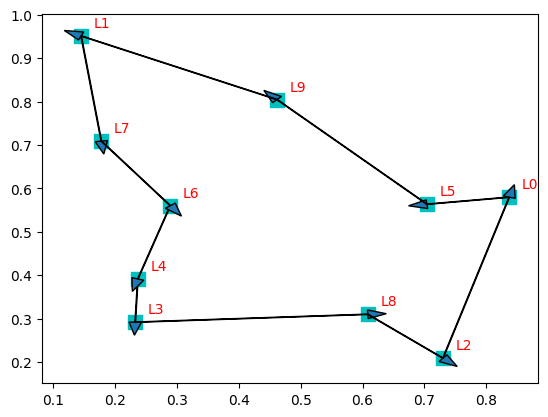

In [78]:
plt.scatter(data["x"], data["y"],c='c', marker='s', s=100)
for i in range(0,len(data)):
    plt.annotate(data['location'].values[i], (data["x"].iloc[i]+0.02, data["y"].iloc[i]+0.02), color='red') 
 
for row in path_solution.itertuples():
    x=row.origin_x
    y=row.origin_y

    dx=row.destination_x - row.origin_x
    dy=row.destination_y - row.origin_y
    
    plt.arrow(x, y, dx, dy, head_width=.02)    